In [1]:
import barmuscomp.scripts.default_path as paths
import barmuscomp.scripts.overall_scripts as scr
import as_seg.data_manipulation as dm
import as_seg.CBM_algorithm as CBM
import as_seg.autosimilarity_computation as as_comp
#import as_seg.barwise_input as bi
from barmuscomp.model.current_plot import *

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl

In [2]:
colors = ['tab:green', 'tab:purple','tab:red','tab:olive']
markers = ['^', 's', 'o','v']

bands_number = 7 
autosimilarity_types = ["Cosine", "Covariance", "RBF"]
pen_function = "modulo8"
features = ["mel_grill", "nn_log_mel_grill"]
features_labels = ["Mel", "NNLMS"]

dimensions_range = [8,16,24,32,40]
lambda_range = [1] #np.concatenate([np.arange(0.1, 2.1, 0.1)])

In [3]:
def compute_this_penalty_lambda_fitting(penalty_func, lambda_range, dimensions_range, autosimilarity_type = "cosine", feature = "nn_log_mel_grill", bands_number = 7, update_rule = "hals", beta = None):
    idx_song_max = 101 # Should be 101 for all the dataset, other values should be for tests only
    songs_range = range(1,idx_song_max) 
    subdivision = 96
    hop_length = 32
    hop_length_seconds = hop_length/44100
    if feature == "pcp":
        dim_range_W = [12]
        init = "chromas"
        dimensions_range = dimensions_range
    else:
        dim_range_W = dimensions_range
        init = "tucker"
    
    results_songs_lambdas = math.inf * np.ones((len(songs_range), len(lambda_range), len(dim_range_W), len(dimensions_range), len(dimensions_range), 2, 3)) # Songs, autosimilarity types, tol, metrics
    repartition_songs_lambdas = np.zeros((len(lambda_range), len(dim_range_W), len(dimensions_range), len(dimensions_range), 40)) # Songs, autosimilarity types, tol, metrics

    for idx_song, song_name in enumerate(songs_range):
        spectrogram, bars, references_segments = scr.load_spec_annot_song_RWC(song_name, feature, hop_length)
        for idx_W, dim_W in enumerate(dim_range_W):
            for idx_H, dim_H in enumerate(dimensions_range):
                for idx_Q, dim_Q in enumerate(dimensions_range):
                    if update_rule == "hals":
                        path_for_ntd = f"{paths.path_data_persisted_rwc}/ntd/{dim_W}_{dim_H}_{dim_Q}"
                        persisted_arguments = f"_{song_name}_{feature}_{init}_96"
                    elif update_rule == "mu":
                        path_for_ntd = f"{paths.path_data_persisted_rwc}/ntd_mu/{dim_W}_{dim_H}_{dim_Q}"
                        persisted_arguments = f"mu_slow_{song_name}_beta{beta}_{feature}_{init}_96_n_iter_max1000"
                    a_factor_path = f"{path_for_ntd}/factors{persisted_arguments}.npy"
                    Q_matrix = np.load(a_factor_path, allow_pickle=True)[2]
                    autosimilarity_Q_matrix = as_comp.switch_autosimilarity(Q_matrix, similarity_type = autosimilarity_type, normalise = True)
                    for idx_lambda, lambda_penalty in enumerate(lambda_range):
                        segments = CBM.compute_cbm(autosimilarity_Q_matrix, penalty_weight = lambda_penalty, penalty_func = penalty_func, bands_number = bands_number)[0]                
                        segments_in_time = dm.segments_from_bar_to_time(segments, bars)
                        for end, start in segments:
                            repartition_songs_lambdas[idx_lambda, idx_W, idx_H, idx_Q, start - end] += 1
                        prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 0.5)
                        prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 3)
                        this_score = [[round(prec05,4),round(rap05,4),round(f_mes05,4)], [round(prec3,4),round(rap3,4),round(f_mes3,4)]]
                        results_songs_lambdas[idx_song, idx_lambda, idx_W, idx_H, idx_Q] = this_score
            
    odd_songs = range(0,idx_song_max - 1,2) # Weird, but shouldn't confuse indexes and number
    even_songs = range(1,idx_song_max - 1,2)
                
    #for idx_lambda, lambda_penalty in enumerate(lambda_range):
        #print(lambda_penalty)
        #plot_lenghts_hist(lengths_all_lambda[idx_lambda])
    
    avg_odd_songs = np.mean(results_songs_lambdas[odd_songs, :,:,:,:,0, 2], axis = 0) + np.mean(np.mean(results_songs_lambdas[odd_songs, :,:,:,:,1, 2], axis = 0))
    best_idx_odd = np.argmax(avg_odd_songs)
    best_args_odd = np.unravel_index(best_idx_odd, np.array(avg_odd_songs).shape)
    print(f"Best args odd: lambda: {lambda_range[best_args_odd[0]]}, dim W: {dim_range_W[best_args_odd[1]]}, dim H: {dimensions_range[best_args_odd[2]]}, dim Q: {dimensions_range[best_args_odd[3]]}")
    res_odd = math.inf * np.ones((2,3))
    for tol in range(2):
        for metric in range(3):
            res_odd[tol, metric] = np.mean(results_songs_lambdas[even_songs, best_args_odd[0], best_args_odd[1],
                                                                 best_args_odd[2], best_args_odd[3], tol, metric])
    
    avg_even_songs = np.mean(results_songs_lambdas[even_songs, :,:,:,:,0, 2], axis = 0) + np.mean(np.mean(results_songs_lambdas[even_songs, :,:,:,:,1, 2], axis = 0))
    best_idx_even = np.argmax(avg_even_songs)
    best_args_even = np.unravel_index(best_idx_even, np.array(avg_even_songs).shape)
    print(f"Best args even: lambda: {lambda_range[best_args_even[0]]}, dim W: {dim_range_W[best_args_even[1]]}, dim H: {dimensions_range[best_args_even[2]]}, dim Q: {dimensions_range[best_args_even[3]]}")
    res_even = math.inf * np.ones((2,3))
    for tol in range(2):
        for metric in range(3):
            res_even[tol, metric] = np.mean(results_songs_lambdas[even_songs, best_args_even[0], best_args_even[1],
                                                                 best_args_even[2], best_args_even[3], tol, metric])    
    return np.mean(np.array([res_odd, res_even]), axis=0)#np.add(np.array(res_odd), np.array(res_even))


In [4]:
def plot_kernels_as(results_diff_as, kernels_or_features, autosimilarities, tol, title = None):
    # Order results_diff_as: kernels ou features, as, tol
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 14})
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    colors = ["#62d5b4", "#317373", "#184a4a"]#['skyblue', 'steelblue', 'darkorange', 'brown']
    
    fig, ax = plt.subplots(1, 1, figsize=(11,4))
    ax.set_ylim( 25, 105 )
    tab = []
    current_start = 0
    for i in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels_or_features))]
        tab.append(ax.bar(indexes, results_diff_as[:,i,tol], color=colors[i], width=width, align='edge'))
        for idx_x, x in enumerate(indexes):
            height = results_diff_as[idx_x, i, tol] 
            plt.text(x +width/2,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2 + j*gap for j in range(len(kernels_or_features))])
    ax.set_xticklabels(kernels_or_features)
    if tol == 1:
        ax.legend(labels=subaxis, loc='lower left')
    else:
        ax.legend(labels=subaxis, loc='lower left')

    ax.set_ylabel("F measure (percentage)")
    #fig.savefig("C:/Users/amarmore/Desktop/Mes papiers/figures/results_barcomp_05.pdf", bbox_inches = "tight")#, format='png')
    if title != None:
        plt.title(title)
    plt.show()

Update: hals, beta: None
Kernel: 14_bands
Feature: mel_grill
Autosimilarity type: Cosine
Best args odd: lambda: 1, dim W: 24, dim H: 40, dim Q: 8
Best args even: lambda: 1, dim W: 8, dim H: 16, dim Q: 32
Autosimilarity type: Covariance
Best args odd: lambda: 1, dim W: 40, dim H: 8, dim Q: 32
Best args even: lambda: 1, dim W: 32, dim H: 16, dim Q: 40
Autosimilarity type: RBF
Best args odd: lambda: 1, dim W: 16, dim H: 8, dim Q: 32
Best args even: lambda: 1, dim W: 32, dim H: 16, dim Q: 8


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.4560,0.4808,0.4651,0.6830,0.7201,0.6966
Autosimilarity: Covariance,0.4151,0.5065,0.4494,0.5880,0.7238,0.6392
Autosimilarity: RBF,0.4700,0.4974,0.4805,0.6777,0.7216,0.6948


Feature: nn_log_mel_grill
Autosimilarity type: Cosine
Best args odd: lambda: 1, dim W: 8, dim H: 24, dim Q: 24
Best args even: lambda: 1, dim W: 8, dim H: 24, dim Q: 24
Autosimilarity type: Covariance
Best args odd: lambda: 1, dim W: 24, dim H: 8, dim Q: 40
Best args even: lambda: 1, dim W: 32, dim H: 16, dim Q: 24
Autosimilarity type: RBF
Best args odd: lambda: 1, dim W: 24, dim H: 8, dim Q: 40
Best args even: lambda: 1, dim W: 40, dim H: 24, dim Q: 16


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.5656,0.5775,0.5697,0.7405,0.7574,0.7463
Autosimilarity: Covariance,0.5186,0.6525,0.5720,0.6506,0.8196,0.7180
Autosimilarity: RBF,0.5460,0.5826,0.5612,0.7319,0.7839,0.7534


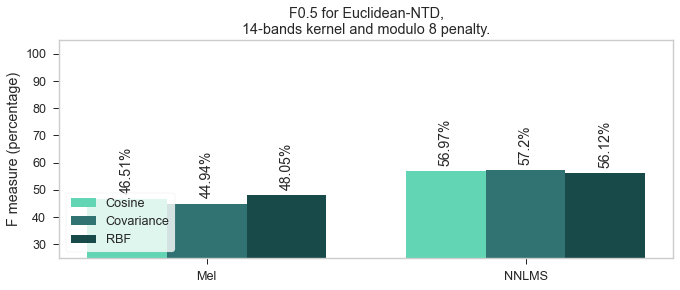

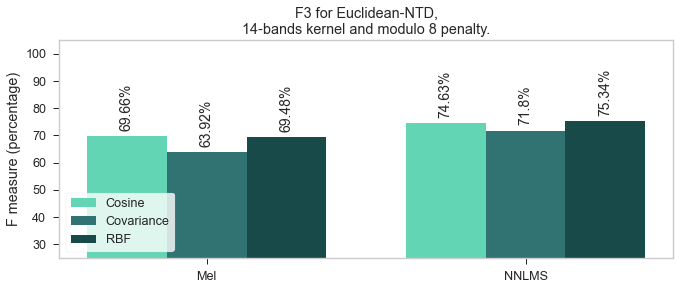

---------------
------------
------------
------------
------------


In [5]:
update_rule = "hals"
beta = None
print(f"Update: {update_rule}, beta: {beta}")

print(f"Kernel: {convolution_type}")

res_avg_target = math.inf * np.ones((len(features), len(autosimilarity_types), 2, 3))

for idx_feat, feature in enumerate(features):
    print(f"Feature: {feature}")
    indexes = []
    results_this_function = math.inf * np.ones((len(autosimilarity_types), 2, 3))
    for idx_as, autosimil_type in enumerate(autosimilarity_types):
        print(f"Autosimilarity type: {autosimil_type}")
        res = compute_this_penalty_lambda_fitting(pen_function, lambda_range, dimensions_range, autosimilarity_type = autosimil_type, feature = feature, convolution_type = convolution_type, update_rule = update_rule, beta = beta)
        results_this_function[idx_as] = res
        indexes.append(f"Autosimilarity: {autosimil_type}")
    res_avg_target[idx_feat] = results_this_function
    dataframe = pd.DataFrame(results_this_function.reshape(results_this_function.shape[0], 6), columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = indexes)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 0, title = f"F0.5 for Euclidean-NTD,\n14-bands kernel and modulo 8 penalty.")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 1, title = f"F3 for Euclidean-NTD,\n14-bands kernel and modulo 8 penalty.")
print("---------------\n------------\n------------\n------------\n------------")

Update: mu, beta: 1
Kernel: 14_bands
Feature: mel_grill
Autosimilarity type: Cosine
Best args odd: lambda: 1, dim W: 40, dim H: 8, dim Q: 32
Best args even: lambda: 1, dim W: 40, dim H: 24, dim Q: 16
Autosimilarity type: Covariance
Best args odd: lambda: 1, dim W: 16, dim H: 8, dim Q: 24
Best args even: lambda: 1, dim W: 16, dim H: 16, dim Q: 32
Autosimilarity type: RBF
Best args odd: lambda: 1, dim W: 40, dim H: 32, dim Q: 8
Best args even: lambda: 1, dim W: 8, dim H: 8, dim Q: 24


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.5550,0.6013,0.5742,0.7369,0.8000,0.7634
Autosimilarity: Covariance,0.5289,0.6041,0.5591,0.6881,0.7889,0.7290
Autosimilarity: RBF,0.5375,0.5894,0.5594,0.7166,0.7850,0.7455


Feature: nn_log_mel_grill
Autosimilarity type: Cosine
Best args odd: lambda: 1, dim W: 24, dim H: 8, dim Q: 32
Best args even: lambda: 1, dim W: 16, dim H: 24, dim Q: 24
Autosimilarity type: Covariance
Best args odd: lambda: 1, dim W: 16, dim H: 16, dim Q: 16
Best args even: lambda: 1, dim W: 24, dim H: 24, dim Q: 24
Autosimilarity type: RBF
Best args odd: lambda: 1, dim W: 8, dim H: 24, dim Q: 16
Best args even: lambda: 1, dim W: 32, dim H: 8, dim Q: 16


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.6034,0.6384,0.6179,0.7825,0.8332,0.8037
Autosimilarity: Covariance,0.5539,0.6822,0.6064,0.6780,0.8436,0.7453
Autosimilarity: RBF,0.6017,0.6520,0.6231,0.7677,0.8354,0.7967


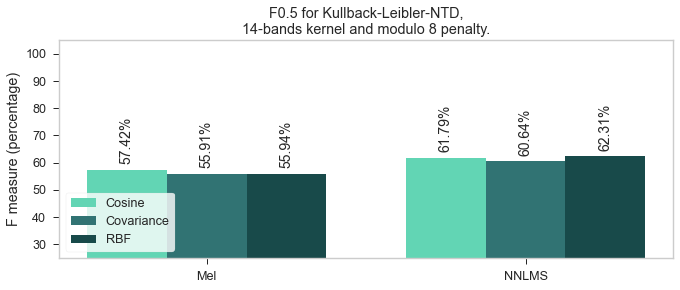

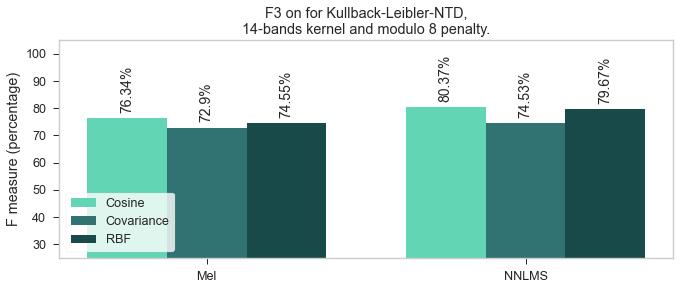

---------------
------------
------------
------------
------------


In [6]:
update_rule = "mu"
beta = 1
print(f"Update: {update_rule}, beta: {beta}")

print(f"Kernel: {convolution_type}")

res_avg_target = math.inf * np.ones((len(features), len(autosimilarity_types), 2, 3))

for idx_feat, feature in enumerate(features):
    print(f"Feature: {feature}")
    indexes = []
    results_this_function = math.inf * np.ones((len(autosimilarity_types), 2, 3))
    for idx_as, autosimil_type in enumerate(autosimilarity_types):
        print(f"Autosimilarity type: {autosimil_type}")
        res = compute_this_penalty_lambda_fitting(pen_function, lambda_range, dimensions_range, autosimilarity_type = autosimil_type, feature = feature, convolution_type = convolution_type, update_rule = update_rule, beta = beta)
        results_this_function[idx_as] = res
        indexes.append(f"Autosimilarity: {autosimil_type}")
    res_avg_target[idx_feat] = results_this_function
    dataframe = pd.DataFrame(results_this_function.reshape(results_this_function.shape[0], 6), columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = indexes)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 0, title = f"F0.5 for Kullback-Leibler-NTD,\n14-bands kernel and modulo 8 penalty.")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 1, title = f"F3 on for Kullback-Leibler-NTD,\n14-bands kernel and modulo 8 penalty.")
print("---------------\n------------\n------------\n------------\n------------")

Update: mu, beta: 0
Kernel: 7 bands
Feature: nn_log_mel_grill
Autosimilarity type: Cosine
Best args odd: lambda: 1, dim W: 32, dim H: 16, dim Q: 32
Best args even: lambda: 1, dim W: 16, dim H: 16, dim Q: 24
Autosimilarity type: RBF
Best args odd: lambda: 1, dim W: 16, dim H: 40, dim Q: 8
Best args even: lambda: 1, dim W: 24, dim H: 8, dim Q: 16


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.5785,0.6411,0.6055,0.7533,0.8343,0.7883
Autosimilarity: RBF,0.5406,0.6005,0.5666,0.7489,0.8349,0.7862


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


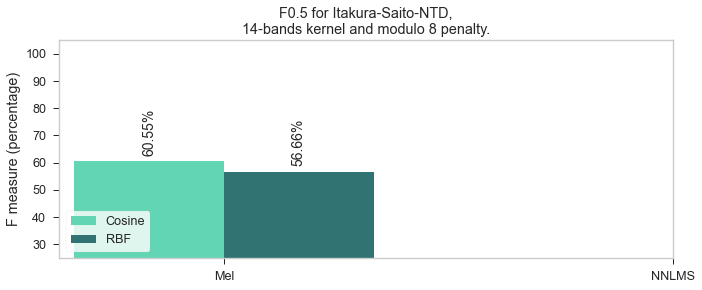

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


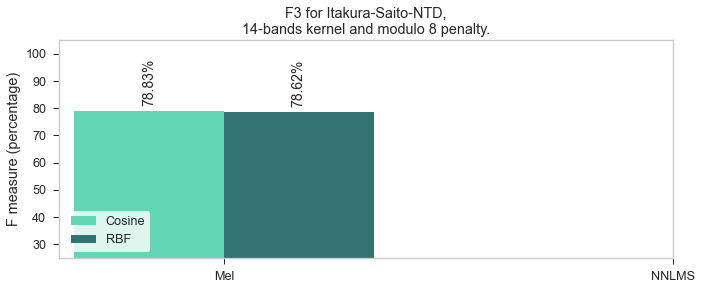

---------------
------------
------------
------------
------------


In [8]:
update_rule = "mu"
beta = 0
print(f"Update: {update_rule}, beta: {beta}")

print(f"Kernel: {bands_number} bands")
autosimilarity_types = ["Cosine", "RBF"]

res_avg_target = math.inf * np.ones((len(features), len(autosimilarity_types), 2, 3))

for idx_feat, feature in enumerate(features[1:]):
    print(f"Feature: {feature}")
    indexes = []
    results_this_function = math.inf * np.ones((len(autosimilarity_types), 2, 3))
    for idx_as, autosimil_type in enumerate(autosimilarity_types):
        print(f"Autosimilarity type: {autosimil_type}")
        res = compute_this_penalty_lambda_fitting(pen_function, lambda_range, dimensions_range, autosimilarity_type = autosimil_type, feature = feature, bands_number = bands_number, update_rule = update_rule, beta = beta)
        results_this_function[idx_as] = res
        indexes.append(f"Autosimilarity: {autosimil_type}")
    res_avg_target[idx_feat] = results_this_function
    dataframe = pd.DataFrame(results_this_function.reshape(results_this_function.shape[0], 6), columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = indexes)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 0, title = f"F0.5 for Itakura-Saito-NTD,\n14-bands kernel and modulo 8 penalty.")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 1, title = f"F3 for Itakura-Saito-NTD,\n14-bands kernel and modulo 8 penalty.")
print("---------------\n------------\n------------\n------------\n------------")

In [12]:
update_rule = "mu"
beta = 0
print(f"Update: {update_rule}, beta: {beta}")

print(f"Kernel: {convolution_type}")
autosimilarity_types = ["Cosine"]


res_avg_target = math.inf * np.ones((len(features), len(autosimilarity_types), 2, 3))

for idx_feat, feature in enumerate(features[1:]):
    print(f"Feature: {feature}")
    indexes = []
    results_this_function = math.inf * np.ones((len(autosimilarity_types), 2, 3))
    for idx_as, autosimil_type in enumerate(autosimilarity_types[:-1]):
        print(f"Autosimilarity type: {autosimil_type}")
        res = compute_this_penalty_lambda_fitting(pen_function, lambda_range, dimensions_range, autosimilarity_type = autosimil_type, feature = feature, convolution_type = convolution_type, update_rule = update_rule, beta = beta)
        results_this_function[idx_as] = res
        indexes.append(f"Autosimilarity: {autosimil_type}")
    res_avg_target[idx_feat] = results_this_function
    dataframe = pd.DataFrame(results_this_function.reshape(results_this_function.shape[0], 6), columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = indexes)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 0, title = f"F0.5 for Itakura-Saito-NTD,\n14-bands kernel and modulo 8 penalty.")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 1, title = f"F3 for Itakura-Saito-NTD,\n14-bands kernel and modulo 8 penalty.")
print("---------------\n------------\n------------\n------------\n------------")

Update: mu, beta: 0
Kernel: 14_bands
Feature: nn_log_mel_grill
Autosimilarity type: Cosine
Best args odd: lambda: 1, dim W: 32, dim H: 16, dim Q: 32
Best args even: lambda: 1, dim W: 16, dim H: 16, dim Q: 24
Autosimilarity type: Covariance


KeyboardInterrupt: 